![](./Media/DCGAN_MNIST.gif)

In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
!pip install einops

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models


import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from einops import rearrange

from latex import latexify
latexify(columns = 2)

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

manualSeed = 999
#manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)

mps
Random Seed:  999


In [2]:
batch_size = 128
image_size = 64
nc = 1
nz = 100
ngf = 64
ndf = 64
num_epochs = 5
lr = 2e-4
beta1 = 0.5

In [3]:
transform = transforms.Compose([transforms.Resize(image_size), transforms.CenterCrop(image_size), transforms.ToTensor(), transforms.Normalize([0.5 for _ in range(nc)], [0.5 for _ in range(nc)])])

In [5]:
mnist_train = datasets.MNIST(root = "../CVDatasets", train = True, transform = transform, download = True)
mnist_test = datasets.MNIST(root = "../CVDatasets", train = False, transform = transform, download = True)

# celebADataset = datasets.ImageFolder(root = "../CVDatasets/CelebA", transform = transform)
# celebALoader = DataLoader(dataset = celebADataset, batch_size = batch_size, shuffle = True)

mnist_train_loader = DataLoader(dataset = mnist_train, batch_size = batch_size, shuffle = True)
mnist_test_loader = DataLoader(dataset = mnist_test, batch_size = batch_size, shuffle = False)

## $$ \text{Generator}:  G_{\phi} $$
## $$ \text{Discriminator}:  D_{\theta} $$
### $$ \min_{\phi} \max_{\theta} V(G, D) = \underset{\textbf{x} \sim p_{\text{data}}}{\mathbb{E}} [\log(D_{\theta}(\textbf{x}))] + \underset{\textbf{z} \sim p_z(\textbf{z})}{\mathbb{E}} [1 - \log(D_{\theta}(G_{\phi}(\textbf{z})))] $$

### Given an $N \times N$ image, $f \times f$ filter size, $s$ as stride and $p$ as the padding, the output dimension is
### $$ \left\lfloor{\frac{N + 2p - f}{s}}\right\rfloor + 1 $$

## Generator - Discriminator Architecture

In [6]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, feature_d):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, feature_d, kernel_size = 4, stride = 2, padding = 1),
            # BatchNorm is skipped for the first layer
            nn.LeakyReLU(0.2),
            self._block(feature_d, feature_d * 2, 4, 2, 1),
            self._block(feature_d * 2, feature_d * 4, 4, 2, 1),
            self._block(feature_d * 4, feature_d * 8, 4, 2, 1),
            nn.Conv2d(feature_d * 8, 1, kernel_size = 4, stride = 2, padding = 0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, feature_g):
        super().__init__()
        self.net = nn.Sequential(
            self._block(channels_noise, feature_g * 16, 4, 1, 0),
            self._block(feature_g * 16, feature_g * 8, 4, 2, 1),
            self._block(feature_g * 8, feature_g * 4, 4, 2, 1),
            self._block(feature_g * 4, feature_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(feature_g * 2, channels_img, kernel_size = 4, stride = 2, padding = 1),
            # No BatchNorm here and Tanh is used in the last layer
            nn.Tanh(),
            # image transformed to be in [-1, 1]
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
            # Initialized with mean 0 and std 0.02

### Model Instantiation

In [8]:
gen = Generator(nz, nc, ngf).to(device)
disc = Discriminator(nc, ndf).to(device)
initialize_weights(gen)
initialize_weights(disc)

### Optimizers and Criterion

In [9]:
opt_gen = torch.optim.Adam(gen.parameters(), lr = lr, betas = (beta1, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr = lr, betas = (beta1, 0.999))
criterion = nn.BCEWithLogitsLoss()

In [10]:
fixed_noise = torch.randn(32, nz, 1, 1).to(device)
gen.train()
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

Epoch [0/5], Batch Step [0/469], Loss D: 0.6396, Loss G: 0.8332


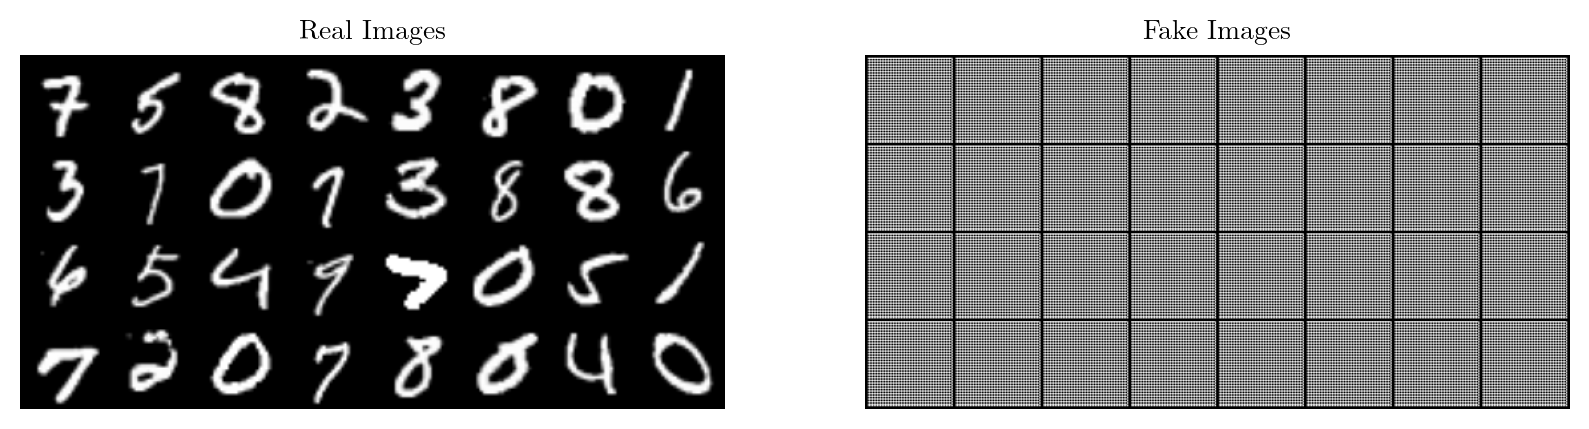

Epoch [0/5], Batch Step [100/469], Loss D: 0.0153, Loss G: 4.0897


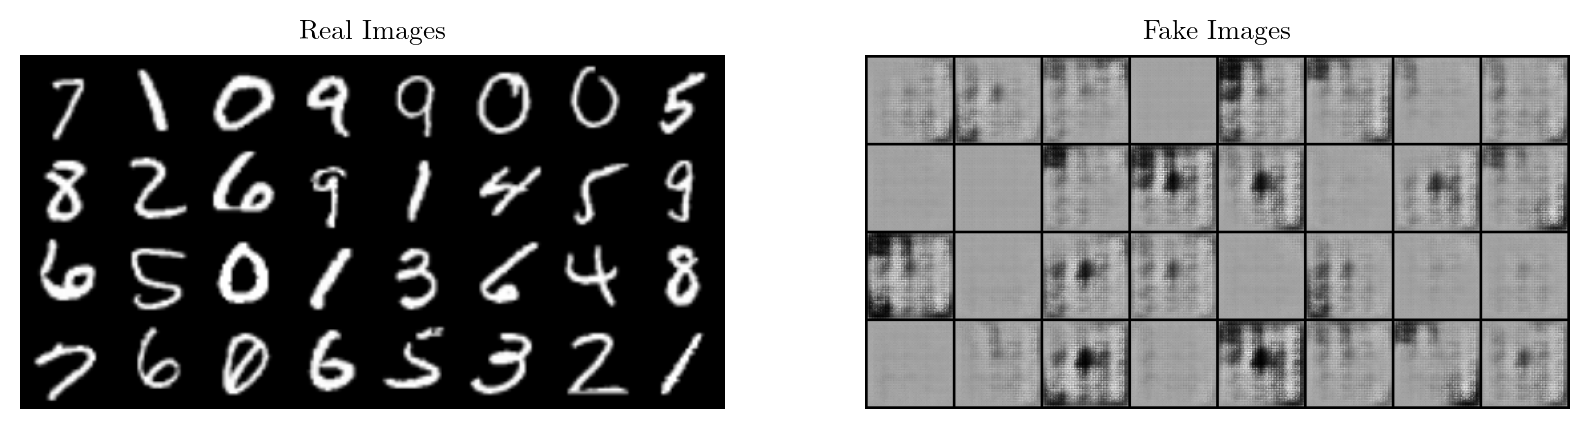

Epoch [0/5], Batch Step [200/469], Loss D: 0.6575, Loss G: 1.2781


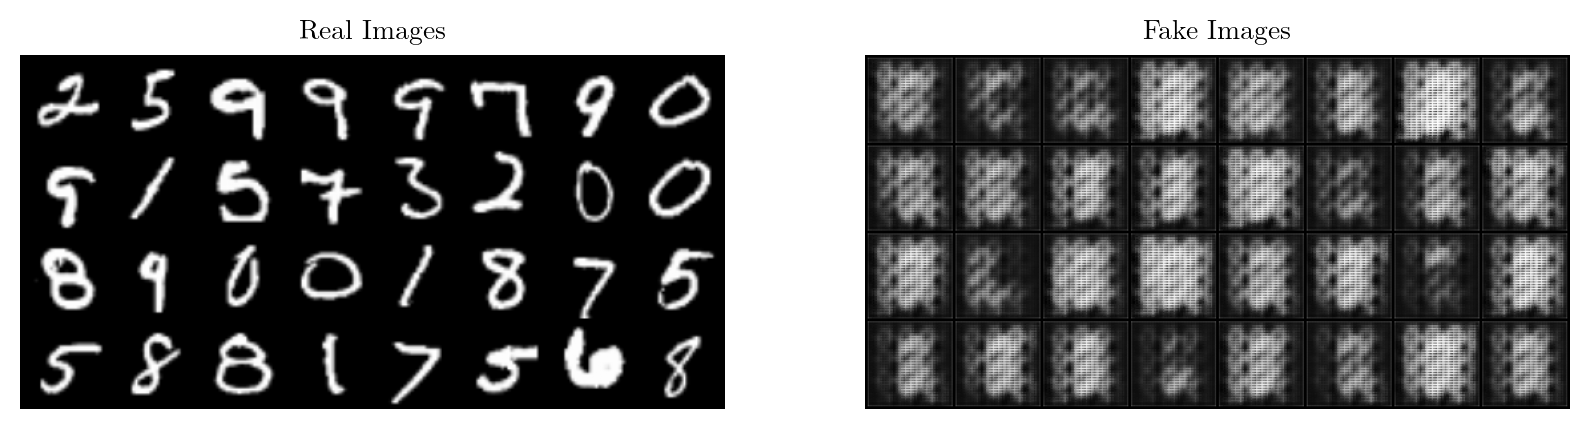

Epoch [0/5], Batch Step [300/469], Loss D: 0.6146, Loss G: 0.8419


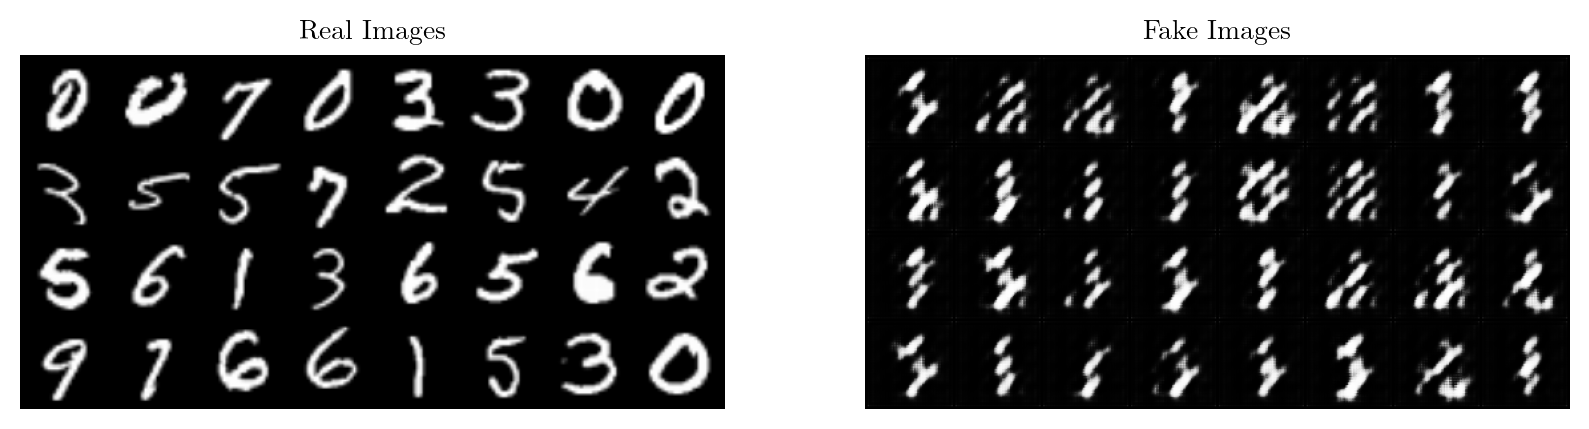

Epoch [0/5], Batch Step [400/469], Loss D: 0.5918, Loss G: 0.9050


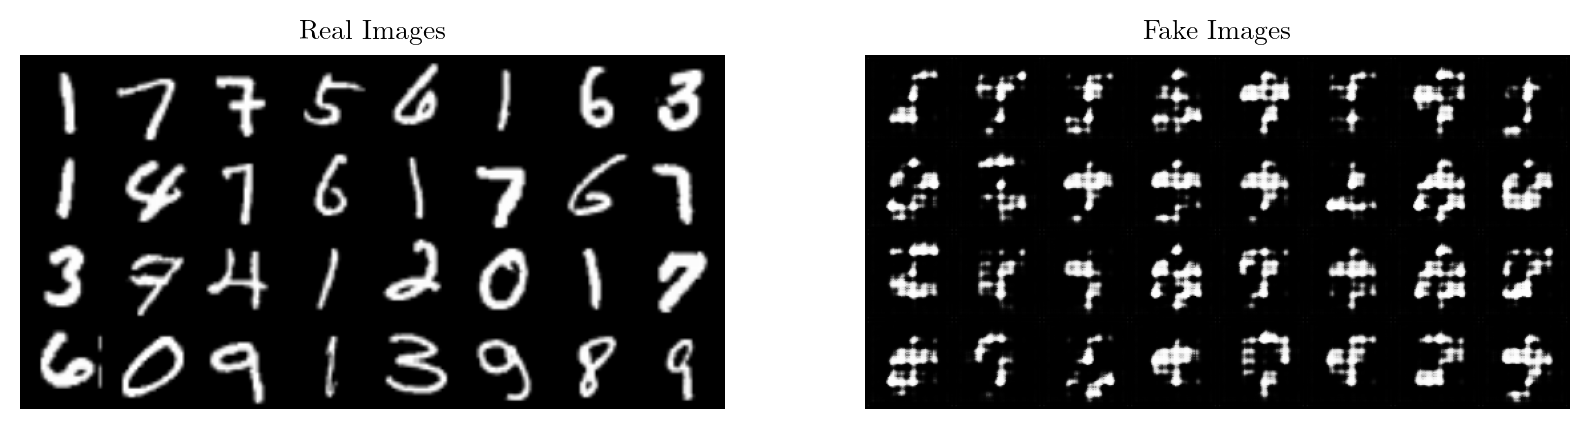

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/5], Batch Step [0/469], Loss D: 0.5435, Loss G: 1.0118


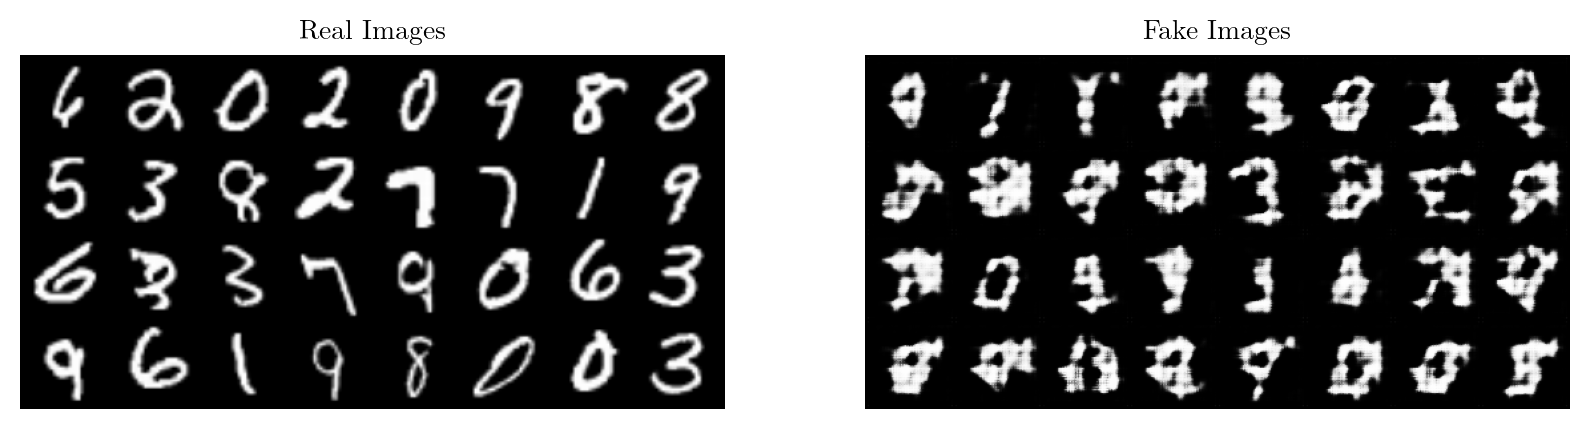

Epoch [1/5], Batch Step [100/469], Loss D: 0.5846, Loss G: 1.1505


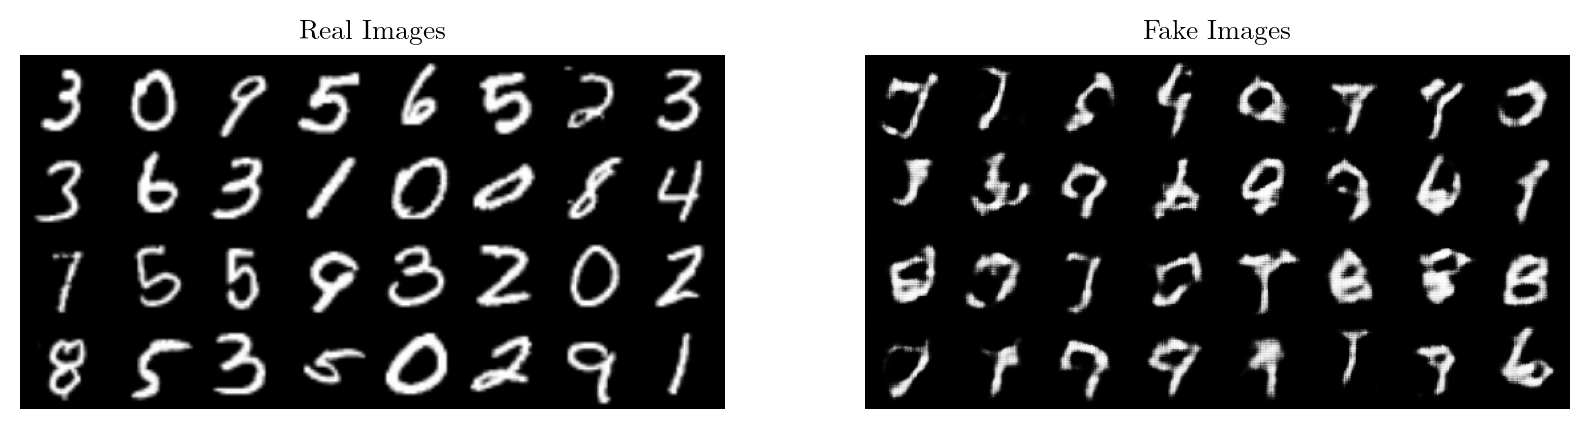

Epoch [1/5], Batch Step [200/469], Loss D: 0.5791, Loss G: 0.8657


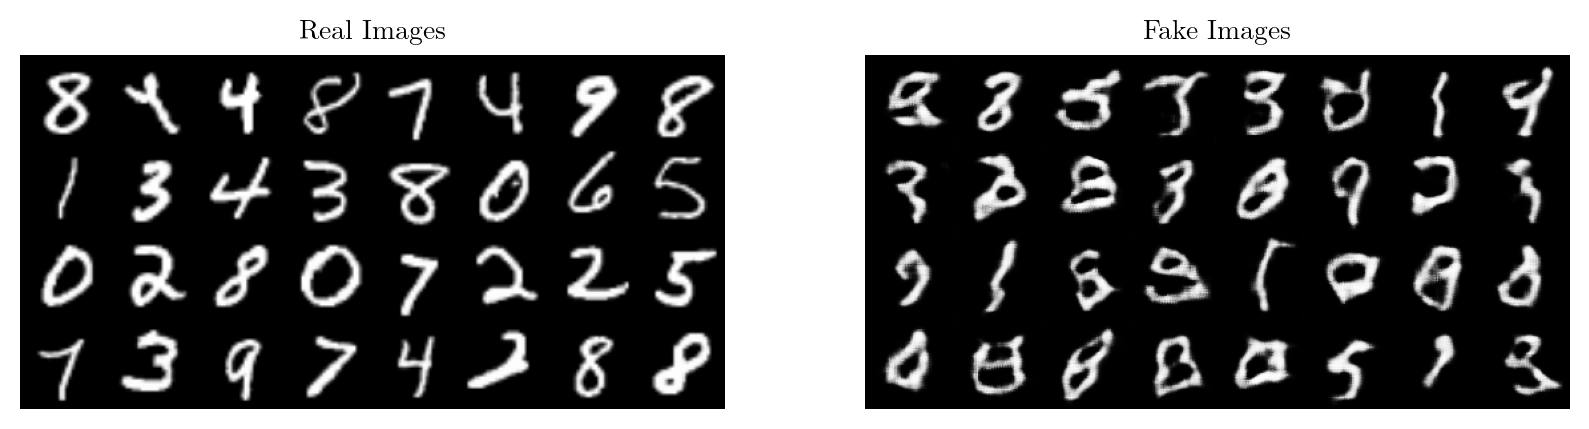

Epoch [1/5], Batch Step [300/469], Loss D: 0.6101, Loss G: 0.9389


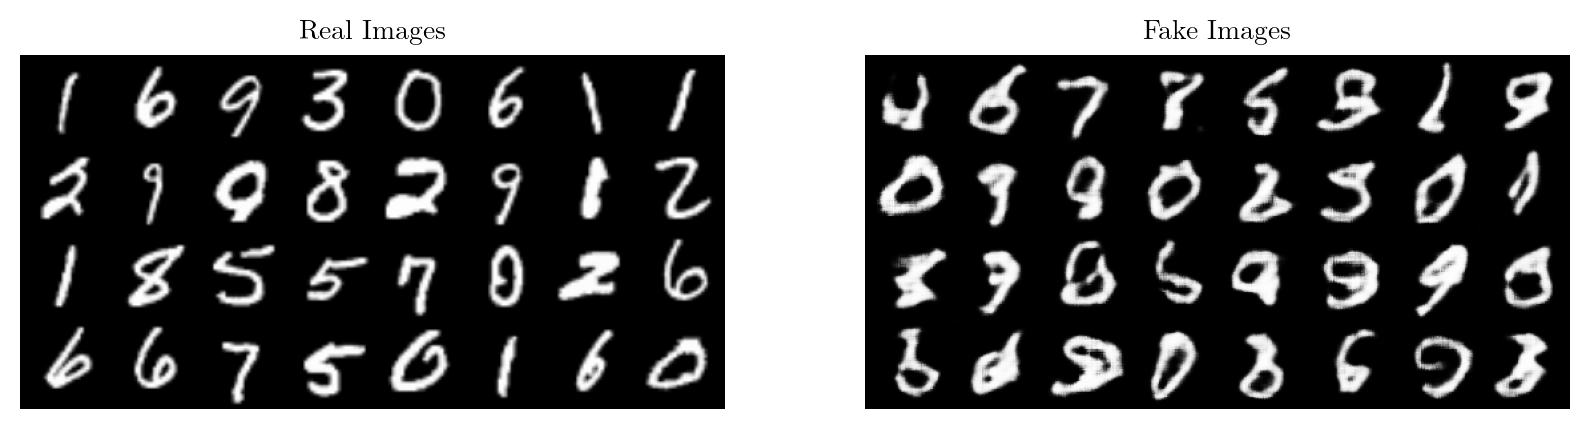

Epoch [1/5], Batch Step [400/469], Loss D: 0.6121, Loss G: 0.9977


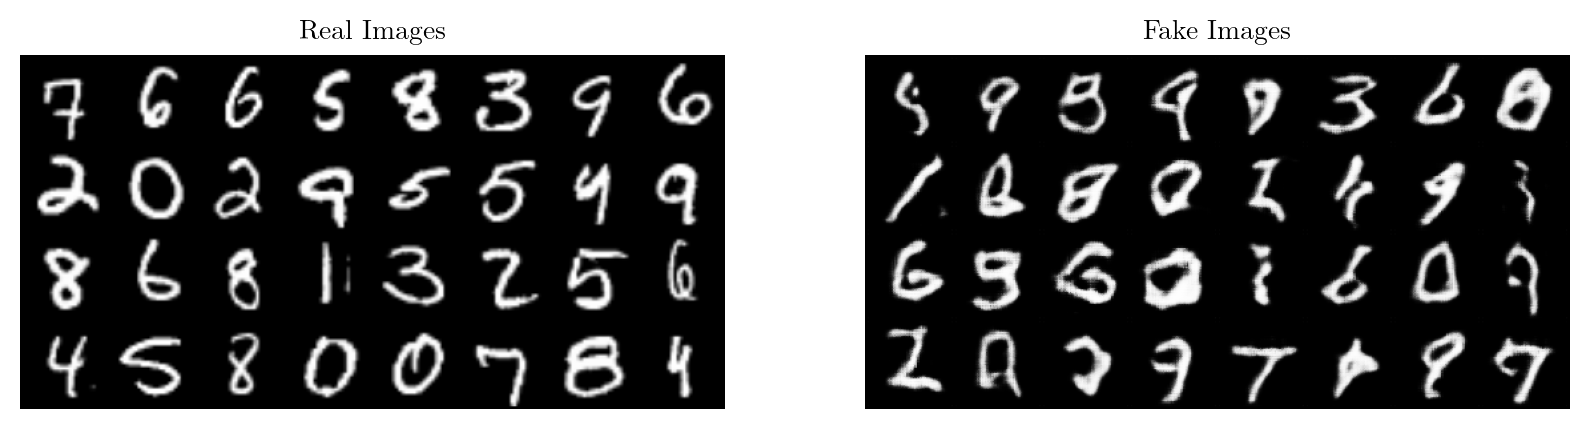

Epoch [2/5], Batch Step [0/469], Loss D: 0.5481, Loss G: 1.8410


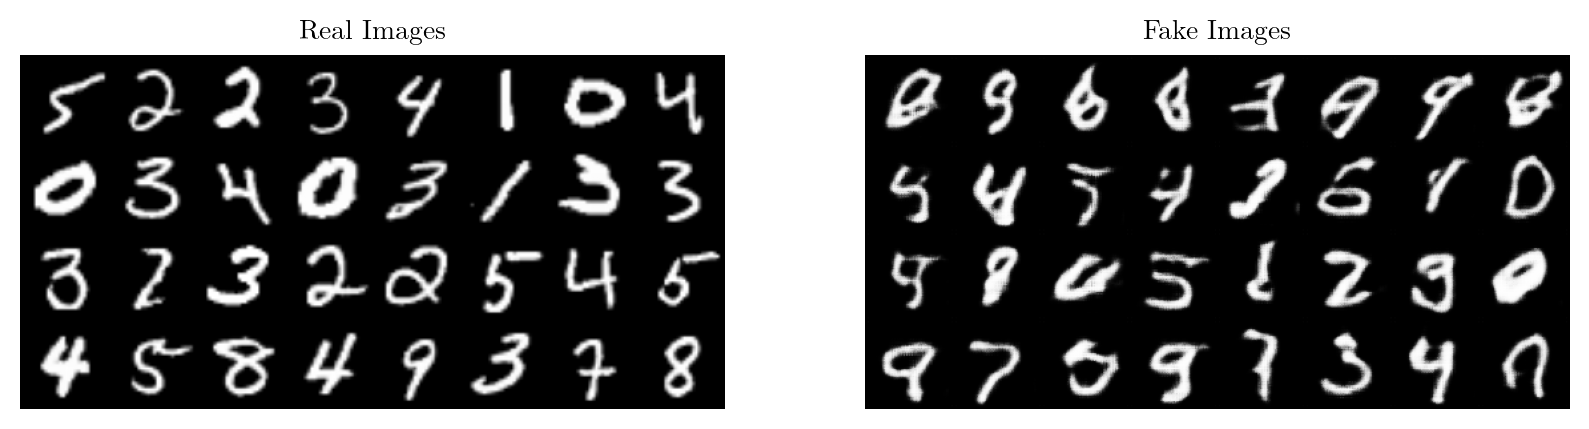

Epoch [2/5], Batch Step [100/469], Loss D: 0.5722, Loss G: 0.6610


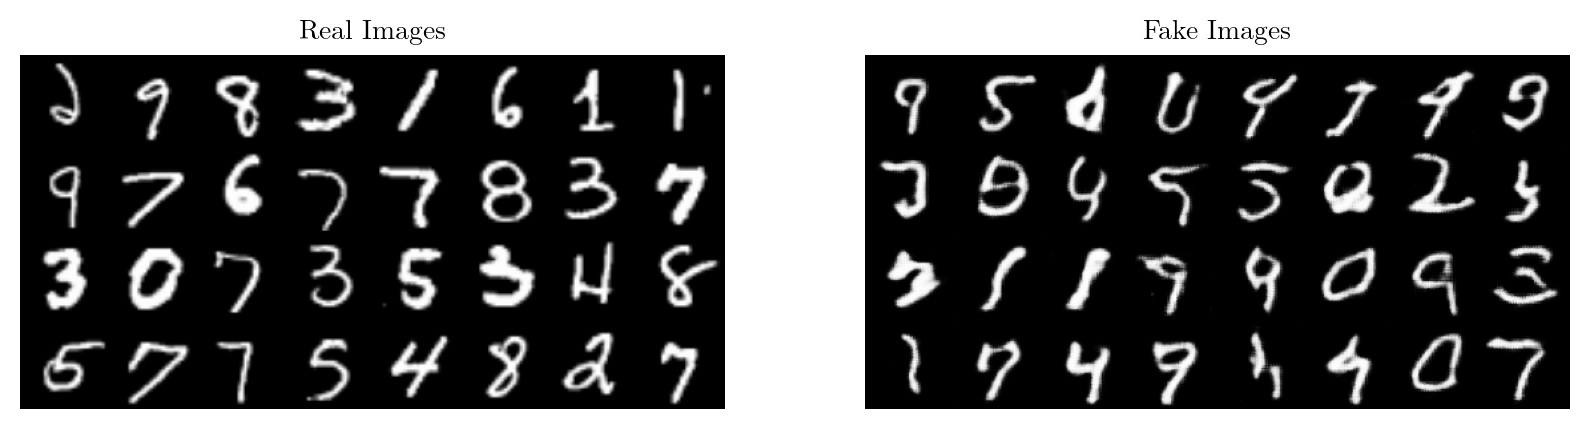

Epoch [2/5], Batch Step [200/469], Loss D: 0.6020, Loss G: 2.2574


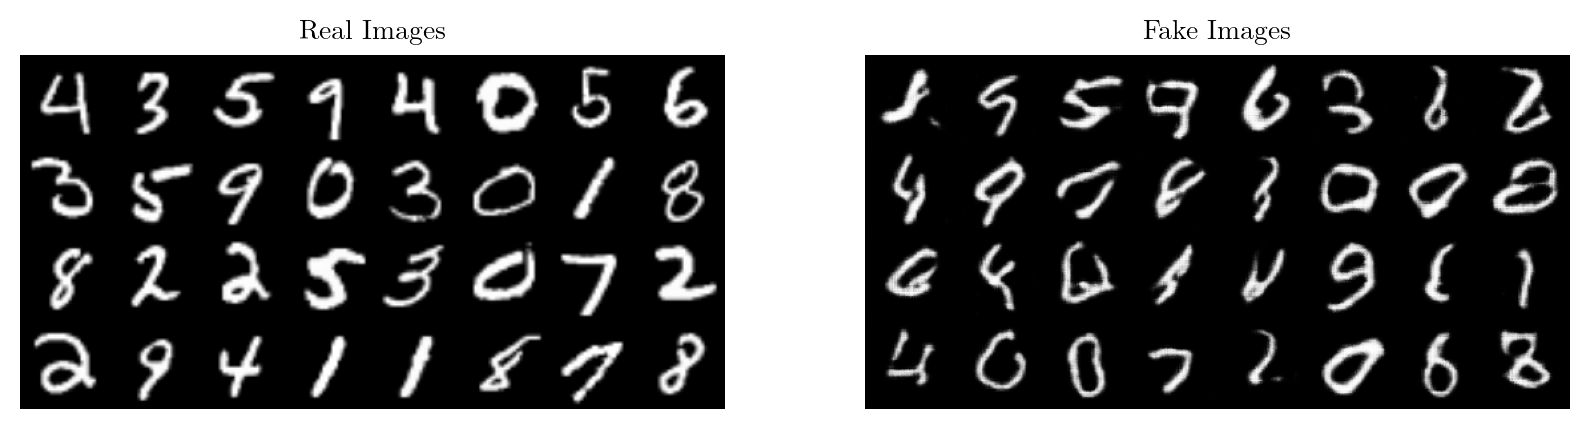

Epoch [2/5], Batch Step [300/469], Loss D: 0.3735, Loss G: 1.5304


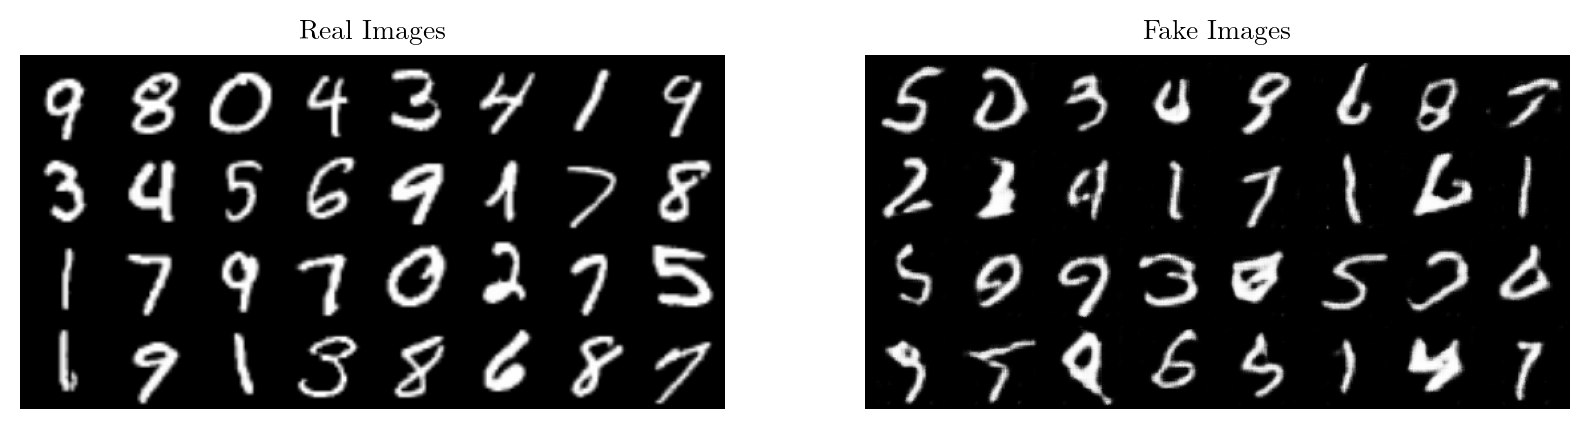

Epoch [2/5], Batch Step [400/469], Loss D: 0.5576, Loss G: 0.6515


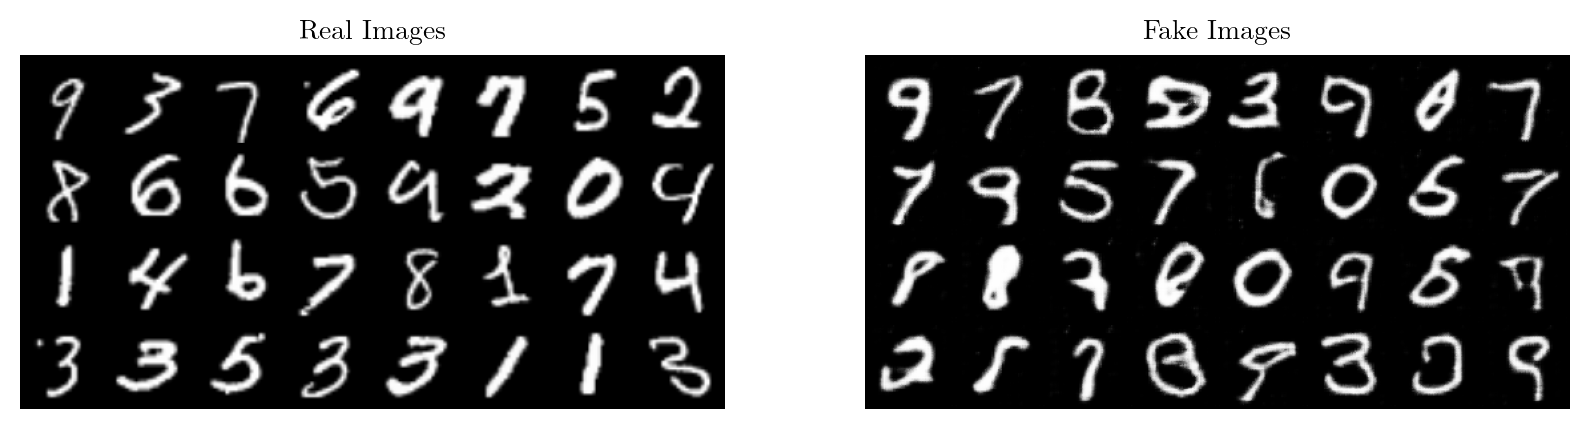

Epoch [3/5], Batch Step [0/469], Loss D: 0.3645, Loss G: 0.9584


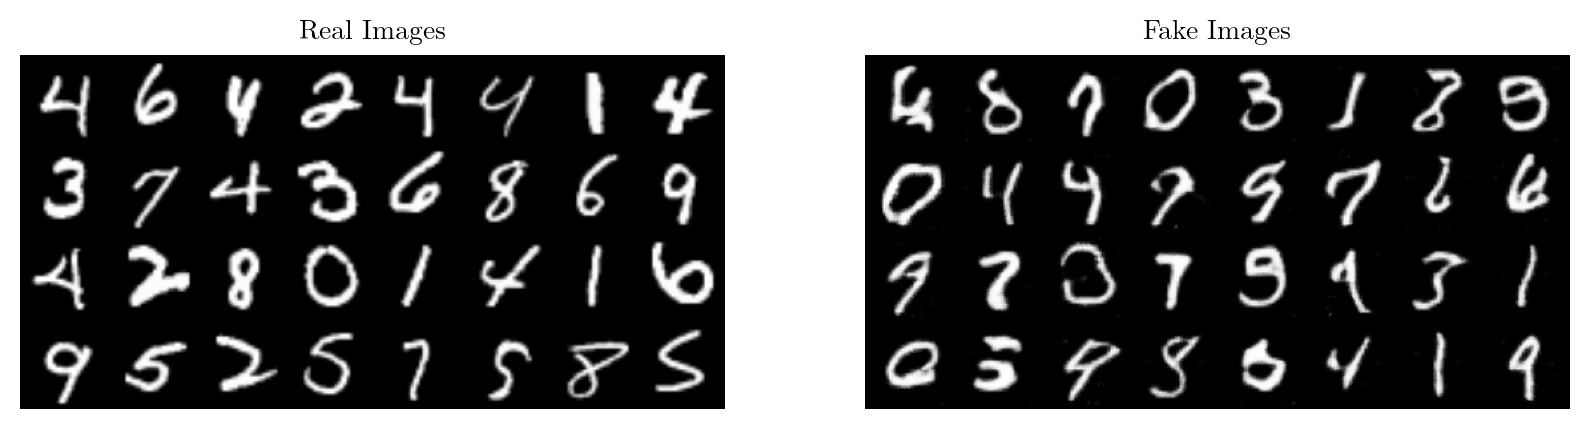

Epoch [3/5], Batch Step [100/469], Loss D: 0.4402, Loss G: 2.8341


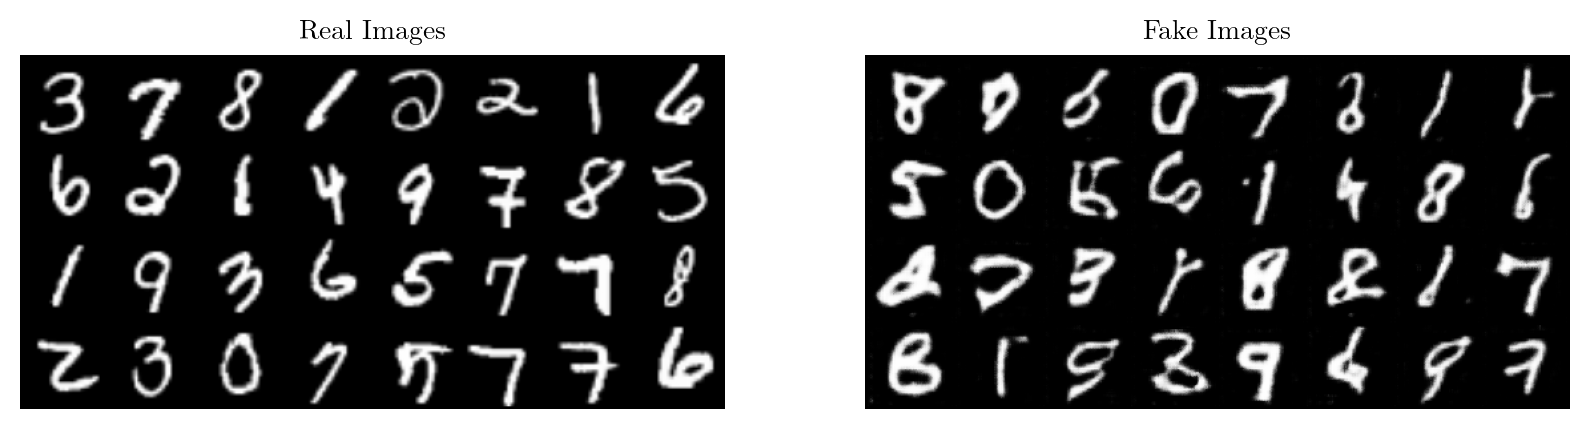

Epoch [3/5], Batch Step [200/469], Loss D: 0.7291, Loss G: 0.7157


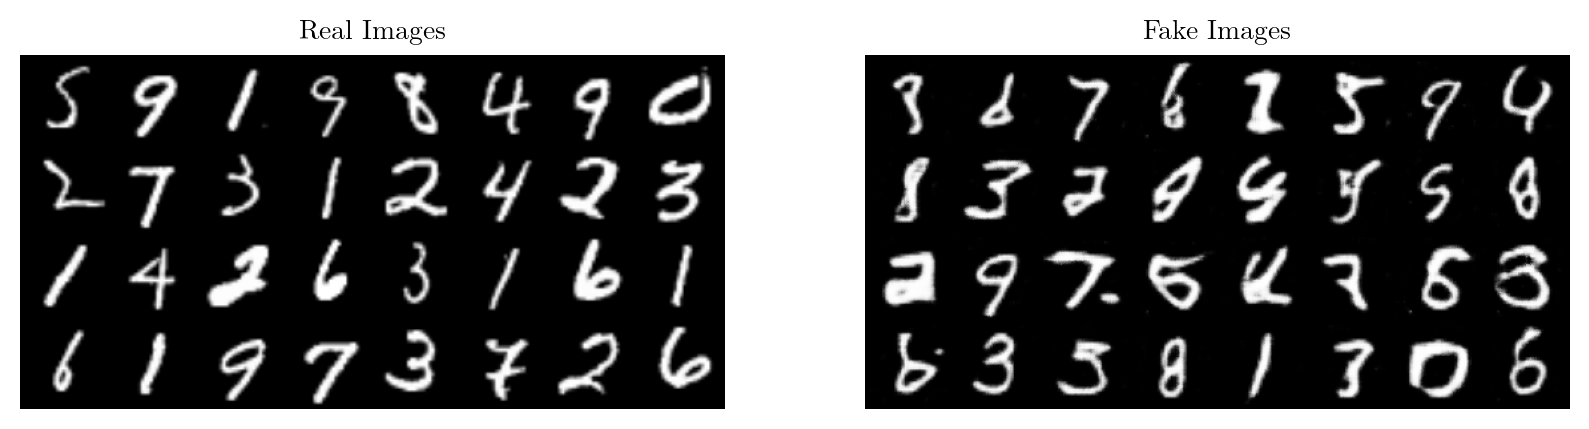

Epoch [3/5], Batch Step [300/469], Loss D: 0.3787, Loss G: 1.6210


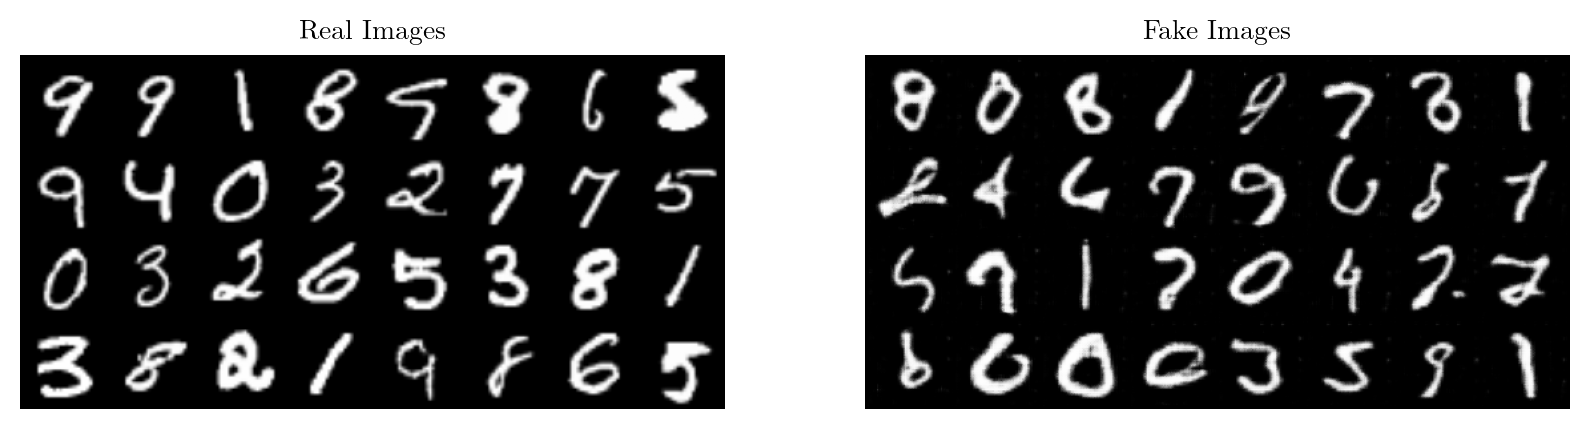

Epoch [3/5], Batch Step [400/469], Loss D: 0.3439, Loss G: 1.8571


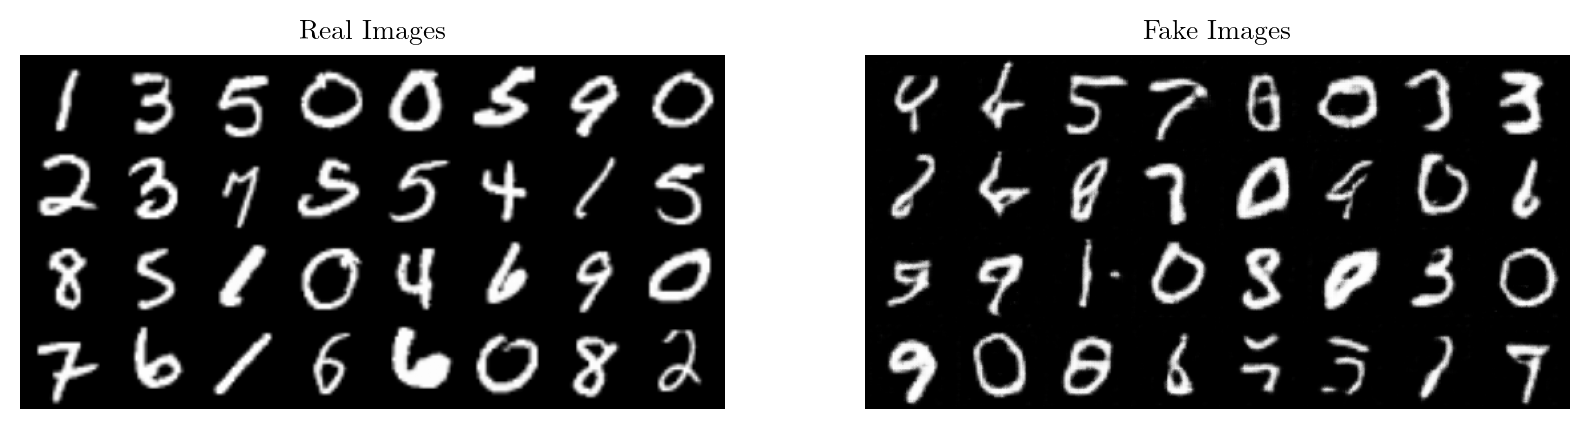

Epoch [4/5], Batch Step [0/469], Loss D: 0.3109, Loss G: 1.9058


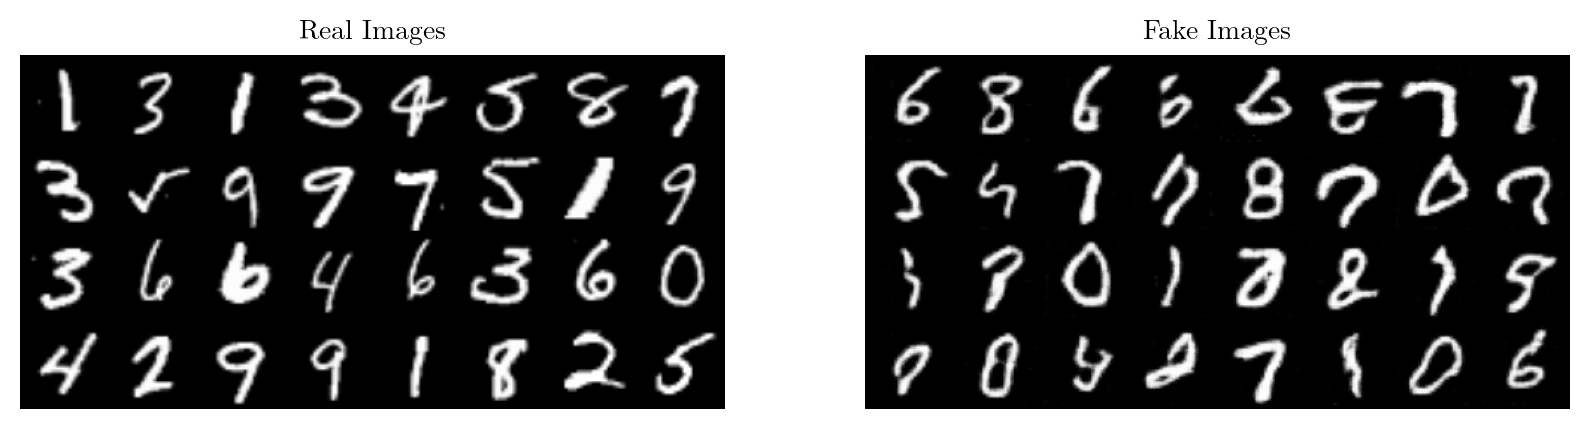

Epoch [4/5], Batch Step [100/469], Loss D: 0.2812, Loss G: 2.7282


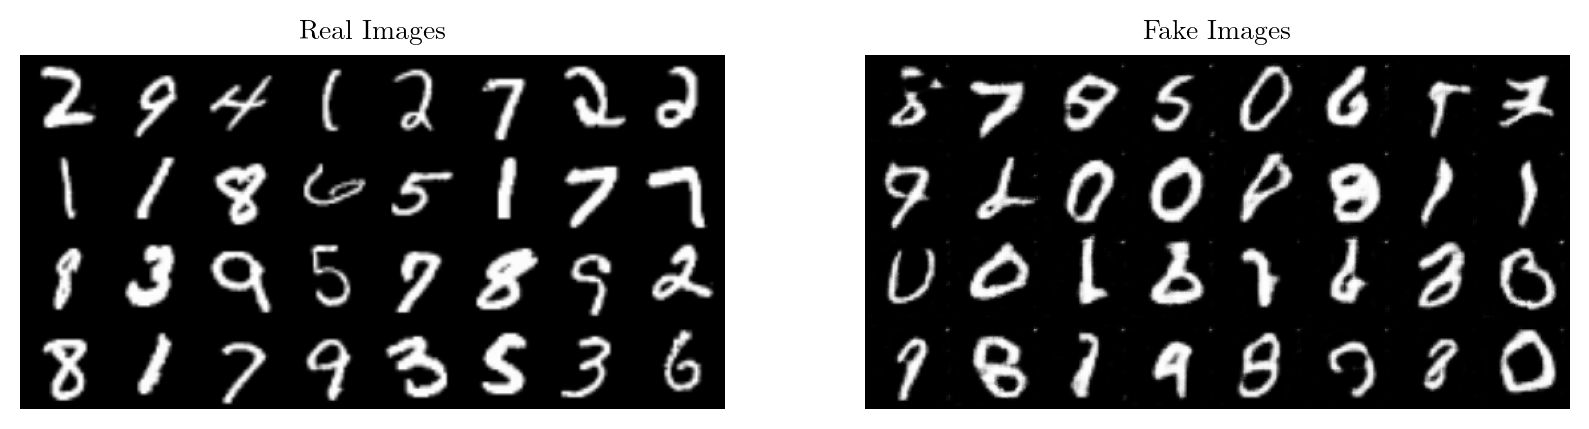

Epoch [4/5], Batch Step [200/469], Loss D: 0.4025, Loss G: 1.6386


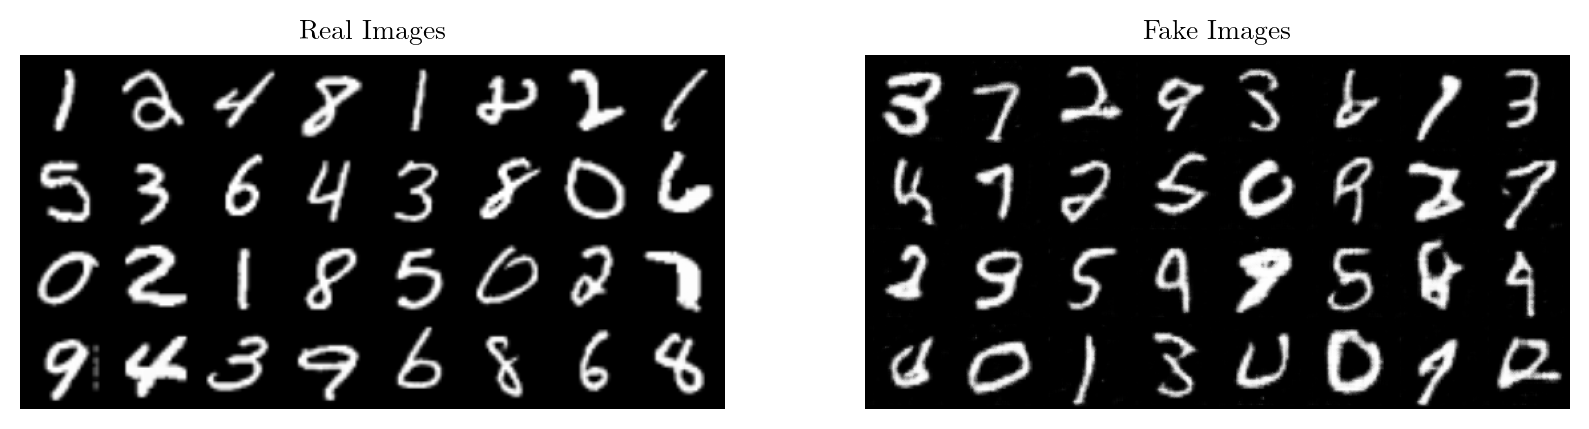

Epoch [4/5], Batch Step [300/469], Loss D: 0.4022, Loss G: 2.9081


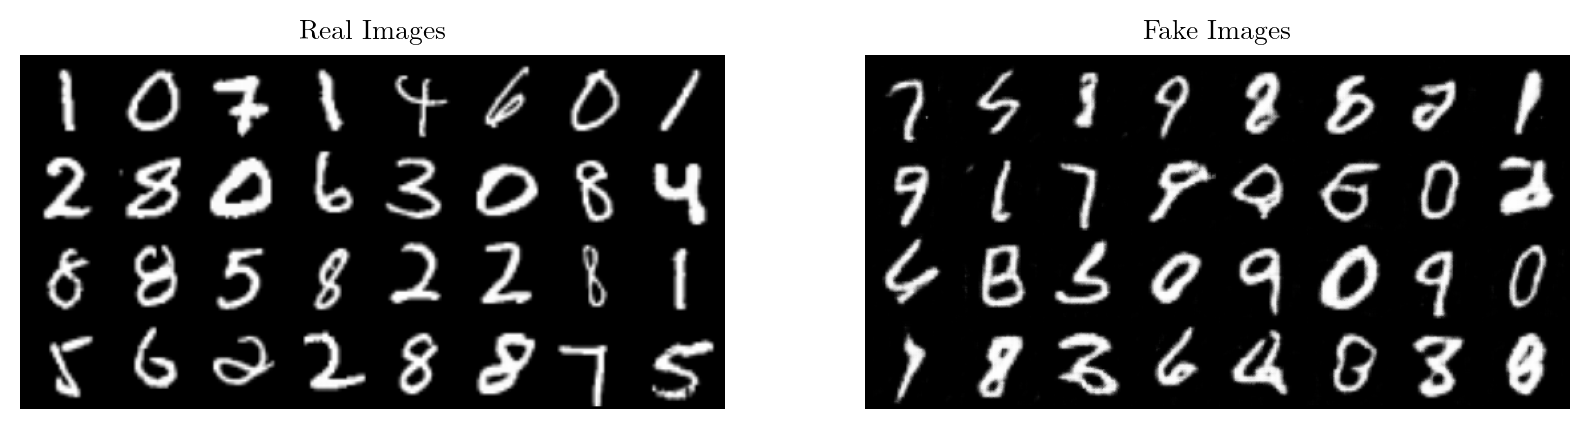

Epoch [4/5], Batch Step [400/469], Loss D: 0.4217, Loss G: 2.0483


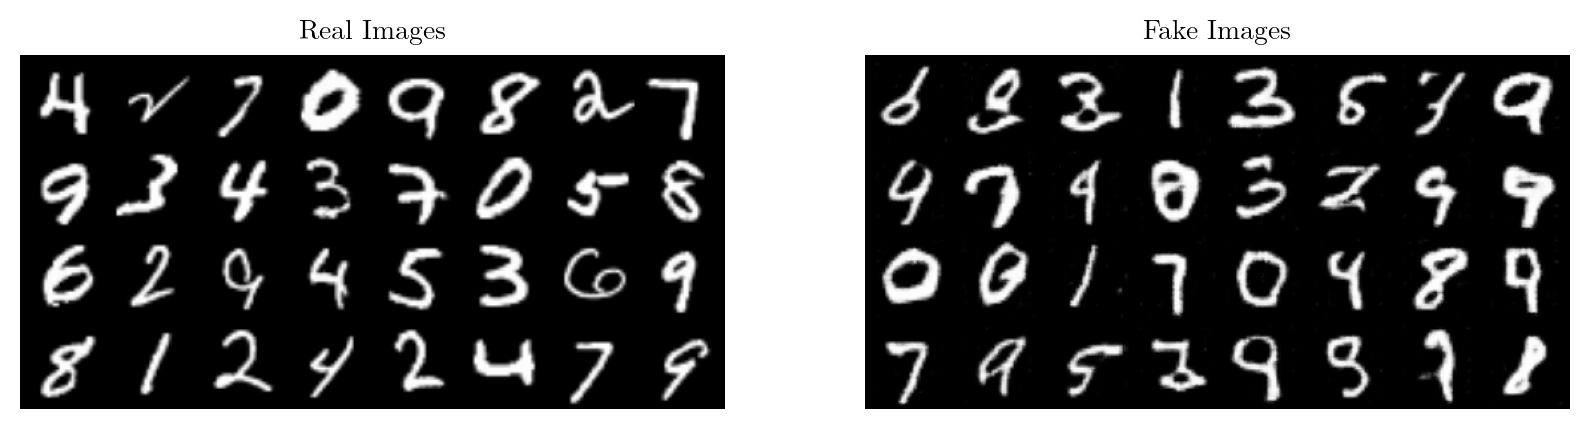

In [12]:
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(mnist_train_loader):
        real = real.to(device)
        noise = torch.randn(batch_size, nz, 1, 1).to(device)
        fake = gen(noise)

        # Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        # BCE(Real, 1) = -log(Real)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)

        # BCE(Fake, 0) = -log(1 - Fake) = -log(Fake)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2

        disc.zero_grad()
        loss_disc.backward(retain_graph = True)
        opt_disc.step()

        # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        # BCE(Fake, 1) = -log(Fake)
        loss_gen = criterion(output, torch.ones_like(output))

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Batch Step [{batch_idx}/{len(mnist_train_loader)}], Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}")

            with torch.no_grad():
                # infer from the Generator by plotting the generated images
                gen.eval()
                fake_noise = torch.randn(32, nz, 1, 1).to(device)
                fake = gen(fake_noise)
                img_grid_real = vutils.make_grid(real[:32], normalize = True)
                img_grid_fake = vutils.make_grid(fake[:32], normalize = True)

                plt.figure(figsize = (10, 10))
                plt.subplot(1, 2, 1)
                plt.axis("off")
                plt.title("Real Images")
                plt.imshow(np.transpose(img_grid_real.cpu().detach().numpy(), (1, 2, 0)))

                plt.subplot(1, 2, 2)
                plt.axis("off")
                plt.title("Fake Images")
                plt.imshow(np.transpose(img_grid_fake.cpu().detach().numpy(), (1, 2, 0)))
                plt.show()

                img = transforms.ToPILImage()(img_grid_fake)
                if not os.path.exists("./DCGAN/MNIST"):
                    os.makedirs("./DCGAN/MNIST")
                img.save(f"./DCGAN/MNIST/{epoch}_{batch_idx}.png")
                gen.train()

    torch.save(gen.state_dict(), "mnist_gen.pth")
    torch.save(disc.state_dict(), "mnist_disc.pth")

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen = Generator(nz, nc, ngf).to(device)
gen.load_state_dict(torch.load("../CVModels/mnist_gen.pth", map_location = device))
gen.eval()

Generator(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(128, 1, 

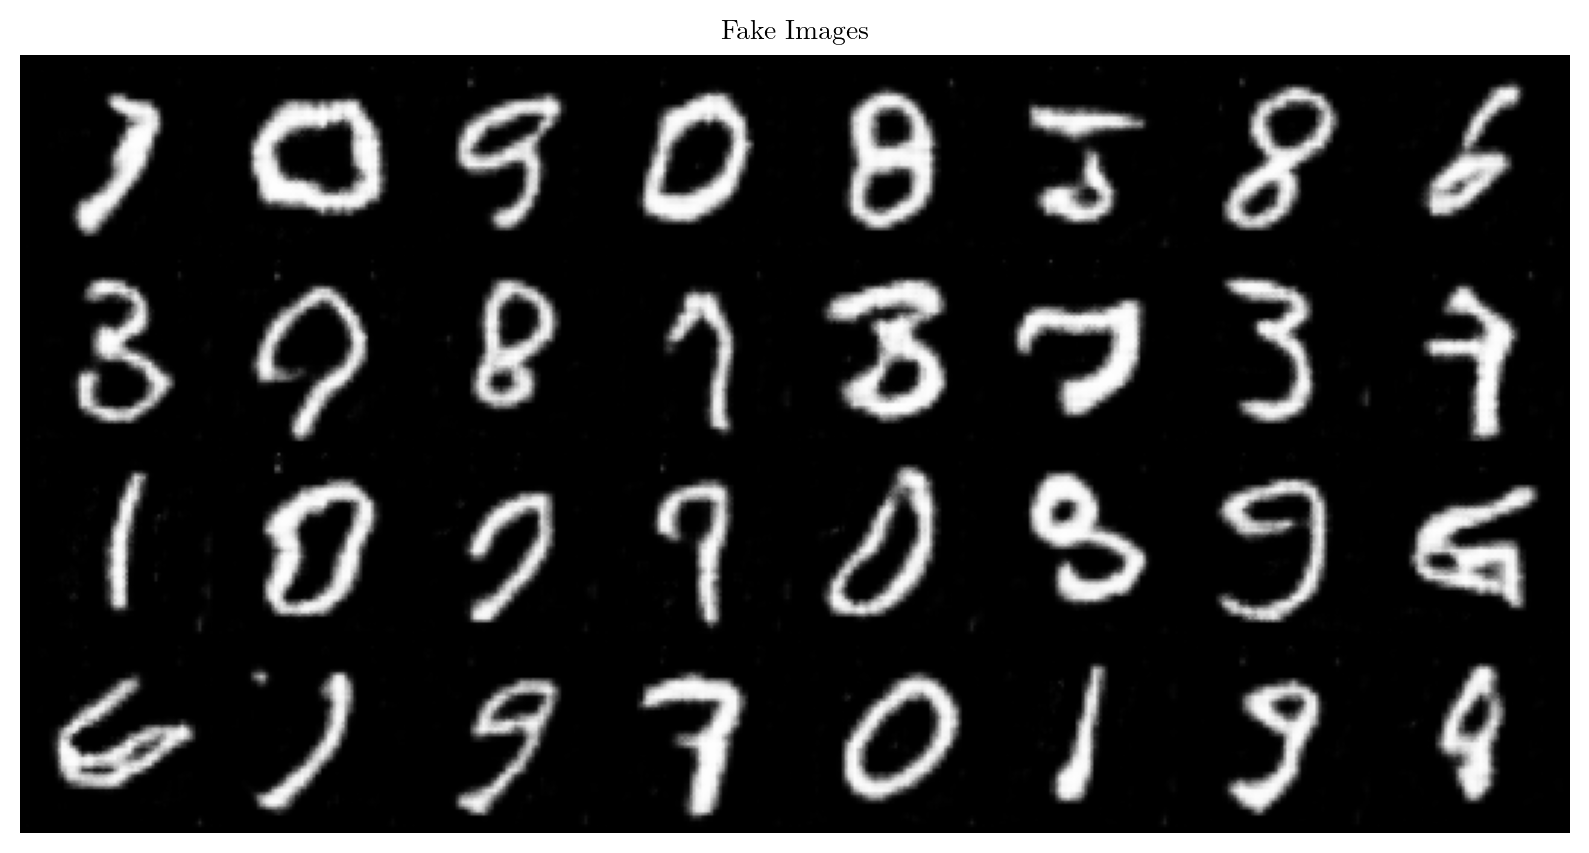

In [15]:
noise = torch.randn(32, nz, 1, 1).to(device)
fake = gen(noise)
img_grid_fake = vutils.make_grid(fake[:32], normalize = True)

plt.figure(figsize = (10, 10))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_grid_fake.cpu().detach().numpy(), (1, 2, 0)))
plt.show()